# **Imports**

In [42]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

# **Variables**

In [43]:
train_size = 30000
valid_size= 3000
num_epochs = 60
batch_size_value = 128

# **Load and view data**

In [44]:
train = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_train_v2.csv')
valid = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_validation_v2.csv')

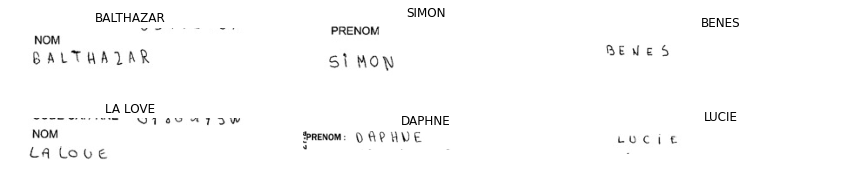

In [45]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

# **Cleaning Data**

In [46]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [47]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

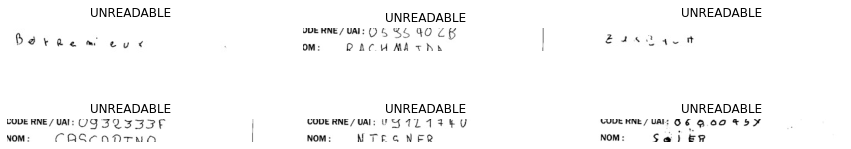

In [48]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [49]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [50]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [51]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

# **Data Preprocessing**

In [52]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [53]:
train_x = []

for i in range(train_size):
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [54]:
valid_x = []

for i in range(valid_size):
    img_dir = '/kaggle/input/handwriting-recognition/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [55]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

# **Convert labels to numerical format and back**

Prepares the data for training a model with CTC loss, which requires numerical labels and their lengths for alignment during training.

In [56]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [57]:
name = 'OUSSAMA'
print(name, '\n',label_to_num(name))

OUSSAMA 
 [14 20 18 18  0 12  0]


In [58]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])    

In [59]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    

In [60]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


# **Build the model**
This model leverages the strengths of both CNNs for feature extraction and RNNs for sequence modeling, making it highly suitable for handwriting recognition tasks.

In [61]:
# Input layer: expects grayscale images of shape (256, 64, 1)
input_data = Input(shape=(256, 64, 1), name='input')

# First Convolutional Block
inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)  
inner = Activation('relu')(inner) 
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  

# Second Convolutional Block
inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)  #
inner = BatchNormalization()(inner) 
inner = Activation('relu')(inner)  
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner) 
inner = Dropout(0.3)(inner)  

# Third Convolutional Block
inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)  # 128 filters, 3x3 kernel
inner = BatchNormalization()(inner) 
inner = Activation('relu')(inner)  
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)  
inner = Dropout(0.3)(inner) 

# Reshape layer to prepare for RNN input
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)  # Reshape to (64, 1024)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner) 

# Recurrent Neural Network (RNN) Layers
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)  # Bidirectional LSTM with 256 units, returns sequences
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)  # Another Bidirectional LSTM with 256 units

# Output layer
inner = Dense(num_of_characters, kernel_initializer='he_normal', name='dense2')(inner) 
y_pred = Activation('softmax', name='softmax')(inner)  

# Model definition
model = Model(inputs=input_data, outputs=y_pred)  
model.summary() 

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 256, 64, 32)       128       
_________________________________________________________________
activation_3 (Activation)    (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 32, 64)      

# **The CTC loss function**

In [62]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [63]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

# **Compile the model**

In [64]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

# **Train our model**

In [65]:
model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=num_epochs, batch_size=batch_size_value)

Epoch 1/60
235/235 [==============================] - 34s 146ms/step - loss: 24.0719 - val_loss: 22.0277
Epoch 2/60
235/235 [==============================] - 33s 138ms/step - loss: 20.1462 - val_loss: 20.2626
Epoch 3/60
235/235 [==============================] - 33s 138ms/step - loss: 19.7767 - val_loss: 19.7904
Epoch 4/60
235/235 [==============================] - 33s 138ms/step - loss: 19.3754 - val_loss: 19.2016
Epoch 5/60
235/235 [==============================] - 32s 138ms/step - loss: 18.8336 - val_loss: 18.7378
Epoch 6/60
235/235 [==============================] - 33s 139ms/step - loss: 17.9873 - val_loss: 17.6345
Epoch 7/60
235/235 [==============================] - 33s 142ms/step - loss: 16.8599 - val_loss: 16.3125
Epoch 8/60
235/235 [==============================] - 33s 139ms/step - loss: 15.4766 - val_loss: 14.4352
Epoch 9/60
235/235 [==============================] - 33s 139ms/step - loss: 13.6807 - val_loss: 13.5536
Epoch 10/60
235/235 [==============================] - 

# **Model performance**

In [66]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [67]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 82.61%
Correct words predicted      : 69.10%


# **Some predictions**

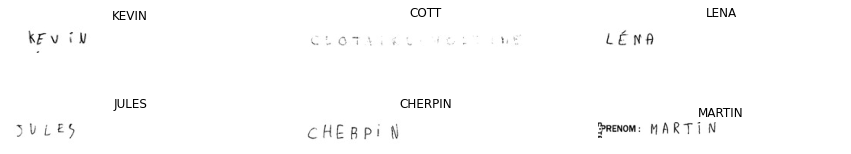

In [68]:
test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

# **Save the model**

In [69]:
# Save the model
model_final.save('handwriting_recognition_model.h5')